# The image before the resizing
to test the image name it "input.jpg"

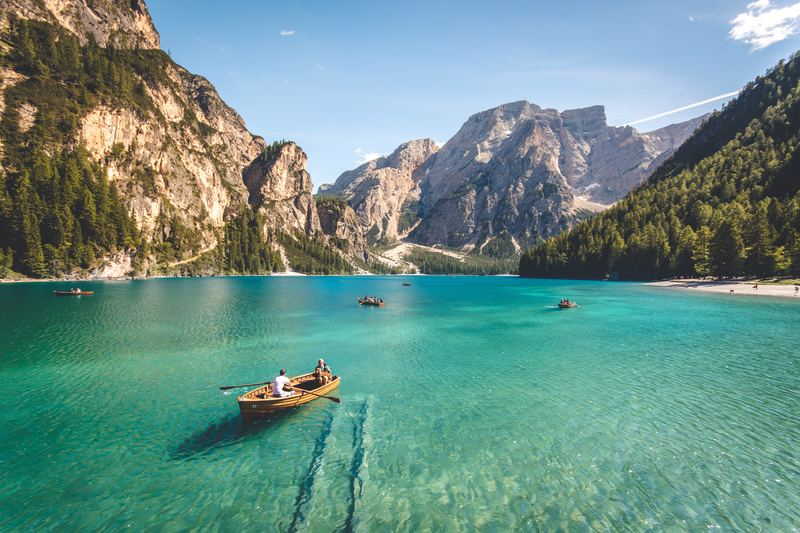

# The code without optimization

In [ ]:
import numpy as np
from imageio.v2 import imread, imwrite  # Updated import
import matplotlib.pyplot as plt

def calc_energy(img):
    """Calculate energy using the required formula e1 = |∂/∂x I| + |∂/∂y I|"""
    # Convert to grayscale if colored
    if len(img.shape) == 3:
        gray = np.mean(img, axis=2)
    else:
        gray = img

    # Calculate x and y derivatives manually
    dx = np.zeros_like(gray)
    dy = np.zeros_like(gray)

    # X derivative
    dx[:, 1:-1] = gray[:, 2:] - gray[:, :-2]
    dx[:, 0] = gray[:, 1] - gray[:, 0]
    dx[:, -1] = gray[:, -1] - gray[:, -2]

    # Y derivative
    dy[1:-1, :] = gray[2:, :] - gray[:-2, :]
    dy[0, :] = gray[1, :] - gray[0, :]
    dy[-1, :] = gray[-1, :] - gray[-2, :]

    # Calculate energy
    energy = np.abs(dx) + np.abs(dy)
    return energy

def find_seam(energy):
    h, w = energy.shape

    # Dynamic programming to find minimum energy path
    dp = energy.copy()
    backtrack = np.zeros_like(energy, dtype=np.int32)  # Changed from np.int to np.int32

    for i in range(1, h):
        for j in range(w):
            if j == 0:
                idx = np.argmin(dp[i-1, j:j+2])
                backtrack[i, j] = idx + j
                min_energy = dp[i-1, idx + j]
            else:
                idx = np.argmin(dp[i-1, max(0, j-1):min(w, j+2)])
                backtrack[i, j] = idx + max(0, j-1)
                min_energy = dp[i-1, idx + max(0, j-1)]

            dp[i, j] += min_energy

    # Backtrack to find the seam
    seam = np.zeros(h, dtype=np.int32)  # Changed from np.int to np.int32
    seam[-1] = np.argmin(dp[-1])
    for i in range(h-2, -1, -1):
        seam[i] = backtrack[i+1, seam[i+1]]

    return seam

def remove_seam(img, seam):
    h, w = img.shape[:2]
    output = np.zeros((h, w-1) + img.shape[2:], dtype=img.dtype)

    for i in range(h):
        col = seam[i]
        output[i, :col] = img[i, :col]
        output[i, col:] = img[i, col+1:]

    return output

def seam_carving(image, scale_c):
    img = image.copy()
    seams_visualization = image.copy()
    h, w = img.shape[:2]
    new_w = int(w * scale_c)
    seams_to_remove = w - new_w

    for i in range(seams_to_remove):
        energy = calc_energy(img)
        seam = find_seam(energy)

        # Visualize seam
        for row in range(h):
            seams_visualization[row, seam[row]] = [255, 0, 0]  # Red color for seam

        img = remove_seam(img, seam)

    return img, seams_visualization

def main():
    # Read image
    input_image = imread('input.jpg')

    # Reduce width to half
    output_image, seams_visual = seam_carving(input_image, 0.5)

    # Save results
    imwrite('output_resized.jpg', output_image)
    imwrite('output_seams.jpg', seams_visual)

if __name__ == '__main__':
    main()

# The time for excution

In [ ]:
import time

start_time = time.time()

# Your main code
input_image = imread('input.jpg')
output_image, seams_visual = seam_carving(input_image, 0.5)
imwrite('output_resized.jpg', output_image)
imwrite('output_seams.jpg', seams_visual)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")


Execution time: 339.09 seconds


# The output resized image

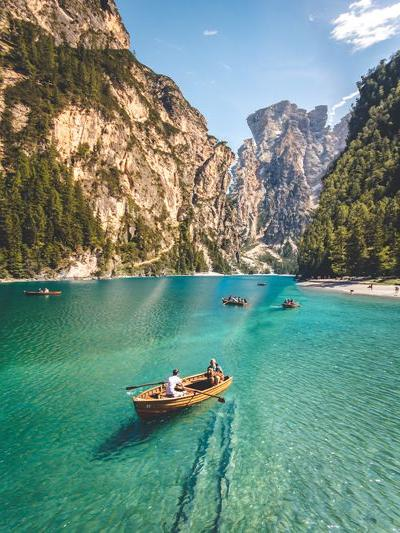

# The image with seams

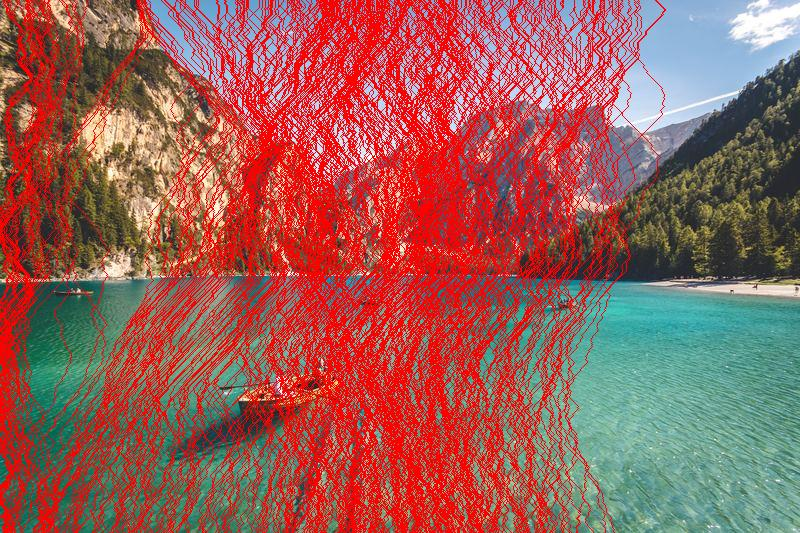

# The optimized code

In [ ]:
import numpy as np
from imageio.v2 import imread, imwrite
from numba import jit
from tqdm import tqdm

@jit(nopython=True)
def calc_energy_fast(gray):
    """Numba-optimized energy calculation"""
    h, w = gray.shape
    energy = np.zeros((h, w))

    # Compute gradients
    for y in range(h):
        for x in range(w):
            # X gradient
            if x == 0:
                dx = abs(gray[y, 1] - gray[y, 0])
            elif x == w-1:
                dx = abs(gray[y, x] - gray[y, x-1])
            else:
                dx = abs(gray[y, x+1] - gray[y, x-1])

            # Y gradient
            if y == 0:
                dy = abs(gray[1, x] - gray[0, x])
            elif y == h-1:
                dy = abs(gray[y, x] - gray[y-1, x])
            else:
                dy = abs(gray[y+1, x] - gray[y-1, x])

            energy[y, x] = dx + dy

    return energy

@jit(nopython=True)
def find_seam_fast(energy):
    """Numba-optimized seam finding"""
    h, w = energy.shape
    dp = energy.copy()
    backtrack = np.zeros((h, w), dtype=np.int32)

    # Forward pass
    for i in range(1, h):
        for j in range(w):
            if j == 0:
                idx = np.argmin(dp[i-1, 0:2])
                backtrack[i, j] = idx
                dp[i, j] += dp[i-1, idx]
            elif j == w-1:
                idx = np.argmin(dp[i-1, j-1:j+1])
                backtrack[i, j] = j - 1 + idx
                dp[i, j] += dp[i-1, j-1+idx]
            else:
                idx = np.argmin(dp[i-1, j-1:j+2])
                backtrack[i, j] = j - 1 + idx
                dp[i, j] += dp[i-1, j-1+idx]

    # Backtrack
    seam = np.zeros(h, dtype=np.int32)
    seam[-1] = np.argmin(dp[-1])
    for i in range(h-2, -1, -1):
        seam[i] = backtrack[i+1, seam[i+1]]

    return seam

@jit(nopython=True)
def remove_seam_fast(img, seam):
    """Numba-optimized seam removal"""
    h, w, c = img.shape
    output = np.zeros((h, w-1, c), dtype=np.uint8)

    for i in range(h):
        col = seam[i]
        output[i, :col] = img[i, :col]
        output[i, col:] = img[i, col+1:]

    return output

def seam_carving(image, scale_c):
    img = image.copy()
    seams_visualization = image.copy()
    h, w = img.shape[:2]
    new_w = int(w * scale_c)
    seams_to_remove = w - new_w

    # Convert to grayscale once
    gray = np.mean(img, axis=2).astype(np.float32)

    # Process with progress bar
    for _ in tqdm(range(seams_to_remove), desc="Removing seams"):
        energy = calc_energy_fast(gray)
        seam = find_seam_fast(energy)

        # Update visualization
        for row in range(h):
            seams_visualization[row, seam[row]] = [255, 0, 0]

        # Remove seam from both color and grayscale images
        img = remove_seam_fast(img, seam)
        gray = np.mean(img, axis=2).astype(np.float32)

    return img, seams_visualization

def main():
    # Read image
    print("Reading image...")
    input_image = imread('input.jpg')
    print(f"Image shape: {input_image.shape}")

    # Optionally resize very large images
    max_size = 800
    if max(input_image.shape[:2]) > max_size:
        scale = max_size / max(input_image.shape[:2])
        new_shape = (int(input_image.shape[1] * scale), int(input_image.shape[0] * scale))
        input_image = cv2.resize(input_image, new_shape)
        print(f"Resized to: {input_image.shape}")

    # Process image
    print("Starting seam carving...")
    output_image, seams_visual = seam_carving(input_image, 0.5)

    # Save results
    print("Saving results...")
    imwrite('output_resized.jpg', output_image)
    imwrite('output_seams.jpg', seams_visual)
    print("Done!")

if __name__ == '__main__':
    main()

Reading image...
Image shape: (533, 800, 3)
Starting seam carving...


Removing seams: 100%|██████████| 400/400 [00:07<00:00, 54.01it/s]

Saving results...
Done!


# The time for excution



In [ ]:
import time

start_time = time.time()

# Your main code
input_image = imread('input.jpg')
output_image, seams_visual = seam_carving(input_image, 0.5)
imwrite('output_resized.jpg', output_image)
imwrite('output_seams.jpg', seams_visual)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")


Removing seams: 100%|██████████| 400/400 [00:06<00:00, 59.57it/s]

Execution time: 6.74 seconds


# The output resized image

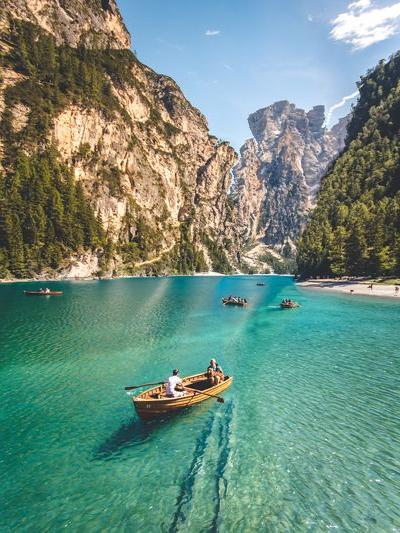

# The output image with seams

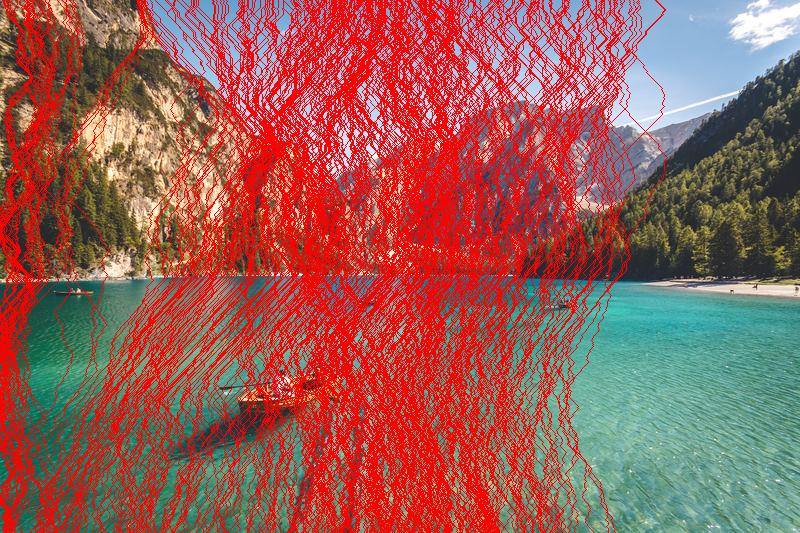